#Torch

In [1]:
!pip3 install 'torch'
!pip3 install 'torchvision'
!pip3 install 'Pillow-SIMD'


import torch
#use GPU if available
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #'cpu' # 'cuda' or 'cpu'
print(DEVICE)

cuda:0


#Download Dataset PACS

In [2]:
!git clone "https://github.com/peteralhachem/unsupervised-domain-adaptation-using-AlexNet.git"

fatal: destination path 'unsupervised-domain-adaptation-using-AlexNet' already exists and is not an empty directory.


#Import Code

In [45]:
import os
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, random_split
from torch.nn.utils import clip_grad_norm_
from torch.backends import cudnn
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.decomposition import PCA
import pandas as pd

In [4]:
import sys
sys.path.append('/content/unsupervised-domain-adaptation-using-AlexNet/DANN_utils')
os.chdir('/content/unsupervised-domain-adaptation-using-AlexNet/DANN_utils')
from alexnet import AlexNet, ReverseLayerF, AlexNetDA
os.chdir('/content/unsupervised-domain-adaptation-using-AlexNet/DANN_utils/PACS')

# Dataset Transformations

In [5]:
# Transformation made on the training dataset.
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),  # Random crop to 224x224
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Transformation made on the testing dataset.
val_transforms = transforms.Compose([
    transforms.Resize(256),  # Resize the shortest side to 256 pixels
    transforms.CenterCrop(224),  # Crop the center to 224x224
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])



In [6]:
art_domain = ImageFolder(root='art_painting', transform=val_transforms)
cartoon_domain  = ImageFolder(root='cartoon',transform=val_transforms)
photo_domain = ImageFolder(root='photo',transform=train_transforms)
sketch_domain = ImageFolder(root='sketch',transform=val_transforms)

# Dataset Visualization

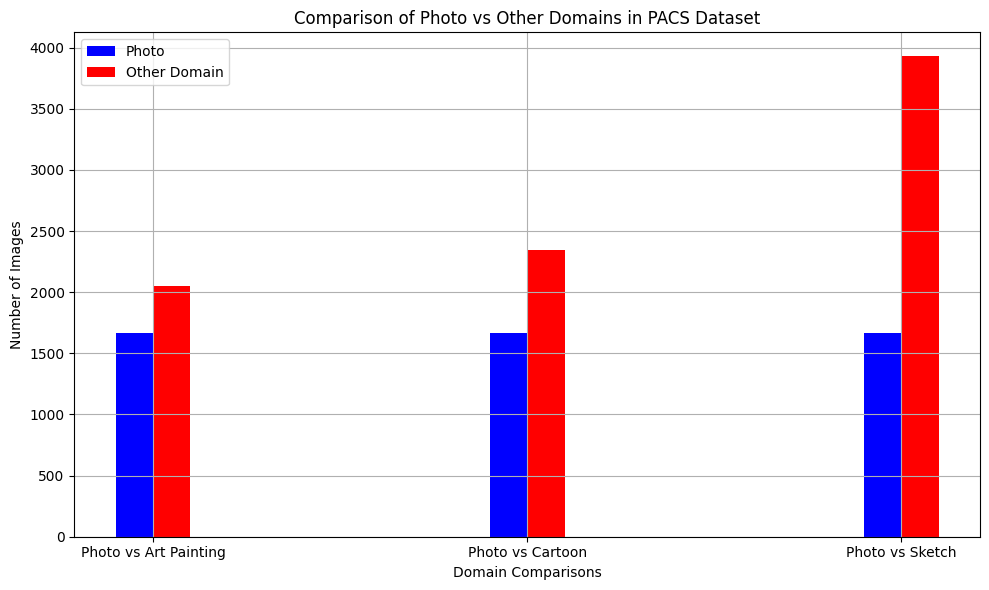

In [ ]:
# Calculate comparison pairs (Photo vs other domains)
photo_comparisons = ['Photo vs Art Painting', 'Photo vs Cartoon', 'Photo vs Sketch']
photo_totals = [len(photo_domain), len(photo_domain), len(photo_domain)]
other_totals = [len(art_domain), len(cartoon_domain), len(sketch_domain)]

# Bar positions
x = np.arange(len(photo_comparisons))
bar_width = 0.1

# Create grouped bar chart
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width / 2, photo_totals, width=bar_width, label='Photo', color='blue')
plt.bar(x + bar_width / 2, other_totals, width=bar_width, label='Other Domain', color='red')

# Add labels and titles
plt.xlabel('Domain Comparisons')
plt.ylabel('Number of Images')
plt.title('Comparison of Photo vs Other Domains in PACS Dataset')
plt.xticks(x, photo_comparisons)
plt.legend()

# Display the chart
plt.tight_layout()
plt.grid()
plt.show()

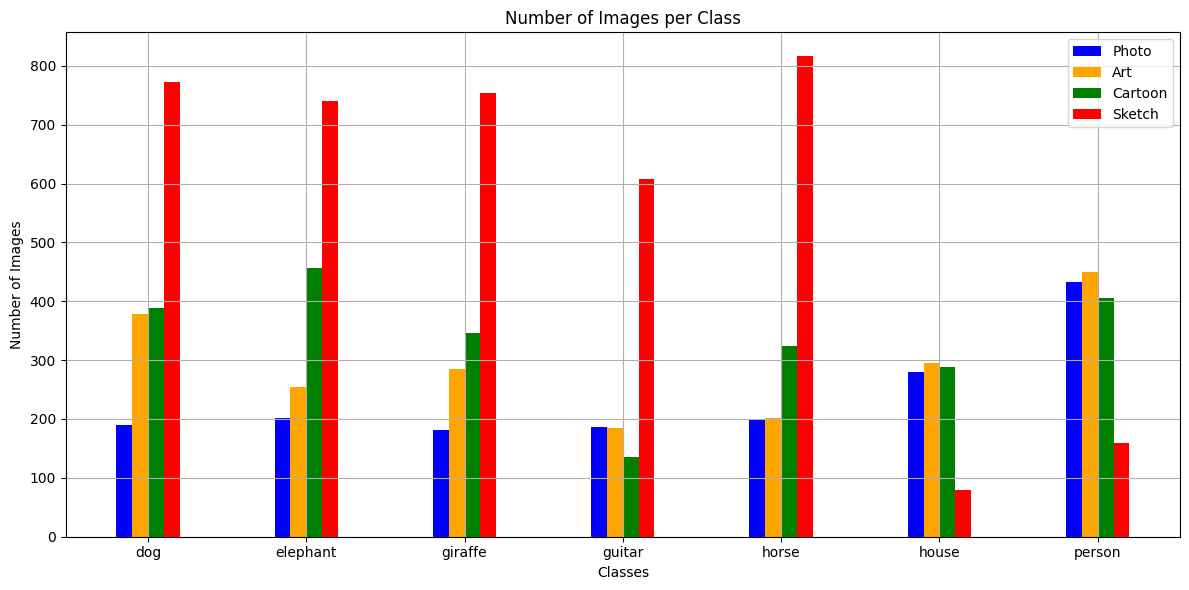

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

classes_dict = {class_name: idx for idx, class_name in enumerate(photo_domain.classes)}

new_class_dict = {}

photo_domain_targets = photo_domain.targets
art_domain_targets = art_domain.targets
cartoon_domain_targets = cartoon_domain.targets
sketch_domain_targets = sketch_domain.targets

# Populate new_class_dict with target counts
for class_name, class_idx in classes_dict.items():
    new_class_dict[class_name] = [
        photo_domain_targets.count(class_idx),
        art_domain_targets.count(class_idx),
        cartoon_domain_targets.count(class_idx),
        sketch_domain_targets.count(class_idx)
    ]

# Create an array of x positions for each class (this will give positions for each dataset)
x = np.arange(len(new_class_dict))  # Positions for classes
bar_width = 0.1  # Width of the bars

# Define a color palette for each domain (ensure the same color for each domain across all classes)
colors = {
    'photo': 'blue',
    'art': 'orange',
    'cartoon': 'green',
    'sketch': 'red'
}

# Create the plot
plt.figure(figsize=(12, 6))

# Plot bars for each class in new_class_dict
for i, (class_name, counts) in enumerate(new_class_dict.items()):
    # Plot each domain with a fixed color
    plt.bar(x[i] - 1.5 * bar_width, counts[0], width=bar_width, label='Photo' if i == 0 else "", color=colors['photo'])
    plt.bar(x[i] - 0.5 * bar_width, counts[1], width=bar_width, label='Art' if i == 0 else "", color=colors['art'])
    plt.bar(x[i] + 0.5 * bar_width, counts[2], width=bar_width, label='Cartoon' if i == 0 else "", color=colors['cartoon'])
    plt.bar(x[i] + 1.5 * bar_width, counts[3], width=bar_width, label='Sketch' if i == 0 else "", color=colors['sketch'])

# Labels and title
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')

# Set x-ticks to the class names
plt.xticks(x, new_class_dict.keys())

# Display the legend
plt.legend()

# Adjust layout and display
plt.tight_layout()
plt.grid()
plt.show()


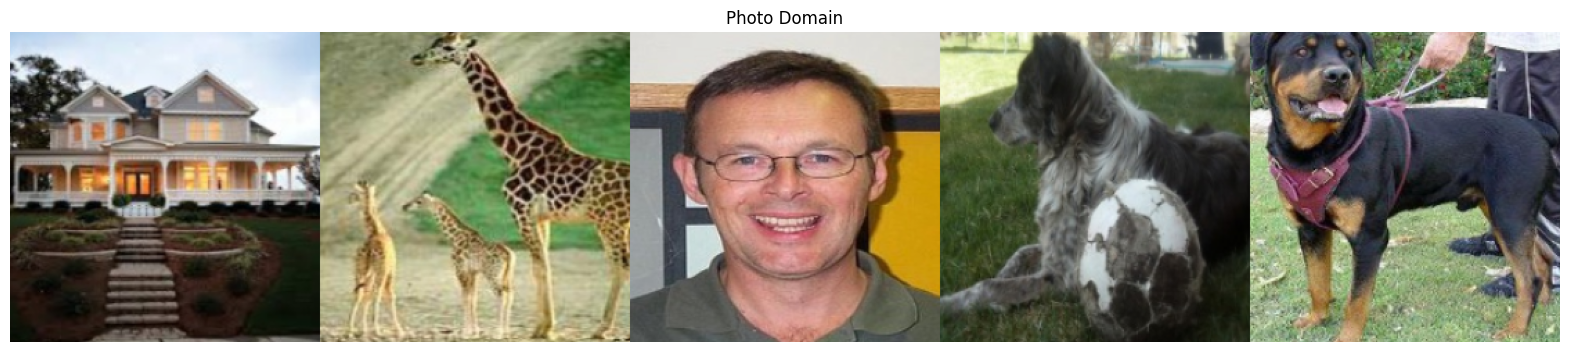

In [ ]:
array_idx = [np.random.randint(0,len(photo_domain)-1) for i in range(5)]

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

image=[]

for idx in array_idx:
  img, label = photo_domain[idx]
  img = img.numpy().transpose((1, 2, 0))
  img = std * img + mean
  img = np.clip(img, 0, 1)
  image.append(img)

plt.figure(figsize=(20, 20))
plt.axis('off')
plt.title('Photo Domain')

plt.imshow(np.concatenate(image, axis=1))
plt.show()

#Train - Without Domain Adaptation

## LR = 0.001, Weight Decay = 5e-5, Momentum = 0.9

In [ ]:
alex_net = AlexNet(num_classes=7, pretrained=True).to(DEVICE)  # New model instance for each lr


In [ ]:
train_size = int(0.7 * len(photo_domain))
val_size = len(photo_domain) - train_size
criterion = nn.CrossEntropyLoss()

model_folder = '/content/saved_models/' + "/" + "NO_DA" + "/" #path to save model
if not os.path.isdir(model_folder):
    os.makedirs(model_folder)

model_checkpoint = 'model'


best_acc = 0.0
best_lr = 0.0
best_epoch = 0

train_accuracy = []
train_loss = []
eval_accuracy = []
eval_loss = []

train_dataset, val_dataset = random_split(photo_domain, [train_size, val_size])

alexnet_no_da = AlexNetDA(alex_net, 2).to(DEVICE)
optimizer = optim.SGD(alexnet_no_da.parameters(), lr=1e-3,momentum=0.9, weight_decay=5e-5)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)

for epoch in range(30):
  alexnet_no_da.train()  # Set the model to training mode

  correct, total = 0, 0

  for i, (inputs, labels) in enumerate(train_loader):
      inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
      optimizer.zero_grad()
      outputs = alexnet_no_da(inputs, alpha=None)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()


  train_accuracy.append(100 * correct / total)
  train_loss.append(loss.item())

  print(f"Epoch {epoch+1}, Training Loss: {loss:.4f},  Training Accuracy: {100 * correct/total:.2f}%")


  alexnet_no_da.eval()  # Validation loop
  with torch.no_grad():
      correct, total, val_loss = 0, 0, 0
      best_state_dict = {}
      for images, labels in val_loader:
          images, labels = images.to(DEVICE), labels.to(DEVICE)
          outputs = alexnet_no_da(images, alpha=None)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          val_loss += criterion(outputs, labels).item()

      val_loss /= len(val_loader)  # Normalize loss
      val_accuracy = 100 * correct / total
      eval_accuracy.append(val_accuracy)
      eval_loss.append(val_loss)
      print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

      if val_accuracy > best_acc:
        save_path_model = os.path.join(model_folder, model_checkpoint)
        torch.save(alexnet_no_da.state_dict(), save_path_model)
        best_acc = val_accuracy

  scheduler.step()

print("The best model has been saved!")


## Plot Training and evaluation accuracy

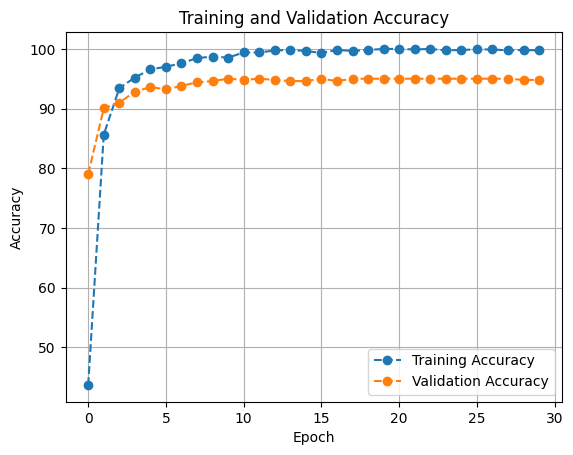

In [ ]:
plt.plot(train_accuracy, label='Training Accuracy', linestyle='dashed', marker='o')
plt.plot(eval_accuracy, label='Validation Accuracy', linestyle='dashed', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


## Plot training and validation loss

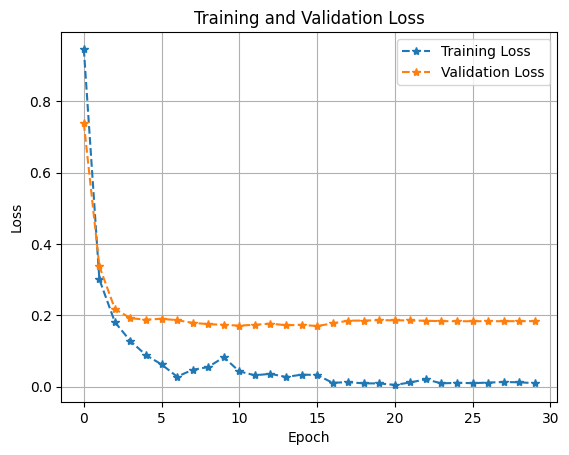

In [ ]:
plt.plot(train_loss, label='Training Loss', linestyle='dashed', marker='*')
plt.plot(eval_loss, label='Validation Loss', linestyle='dashed', marker='*')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

#Test - Without Domain Adaptation

In [ ]:
test_loader = DataLoader(art_domain, batch_size=64, shuffle=False)


# Set model to evaluation mode
alexnet_no_da.eval()

# Define the criterion (optional, if you want to compute loss)
criterion = nn.CrossEntropyLoss()

# Testing Loop
correct = 0
total = 0
test_loss = 0.0

with torch.no_grad():  # No gradient computation needed
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)  # Move data to device
        outputs = alexnet_no_da(inputs)  # Forward pass
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Compute loss (optional)
        test_loss += criterion(outputs, labels).item()

# Compute metrics
test_loss /= len(test_loader)  # Normalize test loss
test_accuracy = 100 * correct / total

# Print results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 2.1522
Test Accuracy: 52.59%


# Train - With Domain Adaptation

In [39]:
alexnet_da = AlexNet(num_classes=7, pretrained=True)
train_loader = DataLoader(photo_domain, batch_size=256, shuffle=True)
test_loader = DataLoader(art_domain, batch_size=64, shuffle=False)

hyperparameters = {
    'LR': [0.1, 0.01, 0.005, 0.001],
    'alpha': [None, 0.5, 0.01, 0.05]
}

In [ ]:
# Create model directory
model_folder = '/content/saved_models/DA/model'
os.makedirs(model_folder, exist_ok=True)

# Initialize metrics storage
train_accuracy = {}
train_loss = {}

for LR in hyperparameters['LR']:
  for ALPHA in hyperparameters['alpha']:

    key = f"{LR}, {ALPHA}"
    print(f"\nTraining with LR: {LR}, alpha: {ALPHA}")

    # Initialize metrics for this configuration
    train_accuracy[key] = []
    train_loss[key] = []

    alexnet_with_da = AlexNetDA(alexnet_da, 2).to(DEVICE)
    optimizer_da = optim.SGD(alexnet_with_da.parameters(), lr=LR, momentum=0.9, weight_decay=5e-5)
    criterion = nn.CrossEntropyLoss()

    best_acc = 0.0
    best_state_dict = None

    for epoch in range(30):
      alexnet_with_da.train()  # Set the model to training mode

      classifier_correct, source_domain_correct, target_domain_correct = 0, 0, 0
      classifier_total, source_total, target_total = 0, 0, 0
      classifier_loss, domain_loss, target_loss = 0, 0, 0

      for i, (inputs, labels) in enumerate(train_loader):

          inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
          optimizer_da.zero_grad()

          outputs = alexnet_with_da(inputs)

          classifier_loss = criterion(outputs, labels)


          _, classifier_predicted = torch.max(outputs.data, 1)
          classifier_total += labels.size(0)
          classifier_correct += (classifier_predicted == labels).sum().item()

          if ALPHA is not None:

            outputs_domain = alexnet_with_da(inputs, alpha=ALPHA)
            domain_loss = criterion(outputs_domain, torch.zeros(outputs_domain.size(0)).long().to(DEVICE))

            _, source_predicted = torch.max(outputs_domain.data, 1)
            source_total += labels.size(0)
            source_domain_correct += (source_predicted == torch.zeros(source_predicted.size(0)).long().to(DEVICE)).sum().item()

            input_target, label_target = next(iter(test_loader))
            input_target = input_target.to(DEVICE)
            label_target = label_target.to(DEVICE)

            outputs_target = alexnet_with_da(input_target, alpha=ALPHA)
            target_loss = criterion(outputs_target, torch.ones(outputs_target.size(0)).long().to(DEVICE))

            _, target_predicted = torch.max(outputs_target.data, 1)
            target_total += label_target.size(0)
            target_domain_correct += (target_predicted == torch.ones(target_predicted.size(0)).long().to(DEVICE)).sum().item()

          loss = (classifier_loss + domain_loss + target_loss)

          loss.backward()
          clip_grad_norm_(alexnet_with_da.parameters(),max_norm=1.0)
          optimizer_da.step()

          total_accuracy = (classifier_correct + source_domain_correct + target_domain_correct) / (classifier_total + source_total + target_total)

      train_loss[key].append(loss.item())
      train_accuracy[key].append(total_accuracy * 100)

      print(f"Epoch {epoch+1:02d} | Loss: {loss:.4f} | Acc: {total_accuracy * 100:.2f}%")

      # Save best model
      if total_accuracy > best_acc:
          best_acc = total_accuracy
          best_state_dict = alexnet_with_da.state_dict()

  # Save best model for this configuration
    if best_state_dict is not None:
      save_path = os.path.join(model_folder, f"lr_{LR}_alpha_{ALPHA}.pth")
      torch.save(best_state_dict, save_path)
      print(f"Saved best model with accuracy: {best_acc * 100:.2f}%")


Training with LR: 0.1, alpha: None
Epoch 01 | Loss: 0.3852 | Acc: 71.86%
Epoch 02 | Loss: 0.0878 | Acc: 93.35%
Epoch 03 | Loss: 0.2393 | Acc: 94.61%
Epoch 04 | Loss: 0.2566 | Acc: 93.95%
Epoch 05 | Loss: 0.1335 | Acc: 94.85%
Epoch 06 | Loss: 0.1650 | Acc: 97.01%
Epoch 07 | Loss: 0.1402 | Acc: 97.90%
Epoch 08 | Loss: 0.0995 | Acc: 97.01%
Epoch 09 | Loss: 0.1236 | Acc: 97.49%
Epoch 10 | Loss: 0.0547 | Acc: 96.77%
Epoch 11 | Loss: 0.0288 | Acc: 98.02%
Epoch 12 | Loss: 0.0726 | Acc: 97.72%
Epoch 13 | Loss: 0.0144 | Acc: 99.04%
Epoch 14 | Loss: 0.0220 | Acc: 98.50%
Epoch 15 | Loss: 0.0229 | Acc: 98.80%
Epoch 16 | Loss: 0.0286 | Acc: 98.38%
Epoch 17 | Loss: 0.0873 | Acc: 99.28%
Epoch 18 | Loss: 0.1488 | Acc: 98.32%
Epoch 19 | Loss: 0.0747 | Acc: 98.20%
Epoch 20 | Loss: 0.0051 | Acc: 98.56%
Epoch 21 | Loss: 0.0091 | Acc: 98.80%
Epoch 22 | Loss: 0.0343 | Acc: 98.50%
Epoch 23 | Loss: 0.0090 | Acc: 98.80%
Epoch 24 | Loss: 0.2023 | Acc: 98.08%
Epoch 25 | Loss: 0.0106 | Acc: 98.26%
Epoch 26 | Los

### Plot Training accuracy

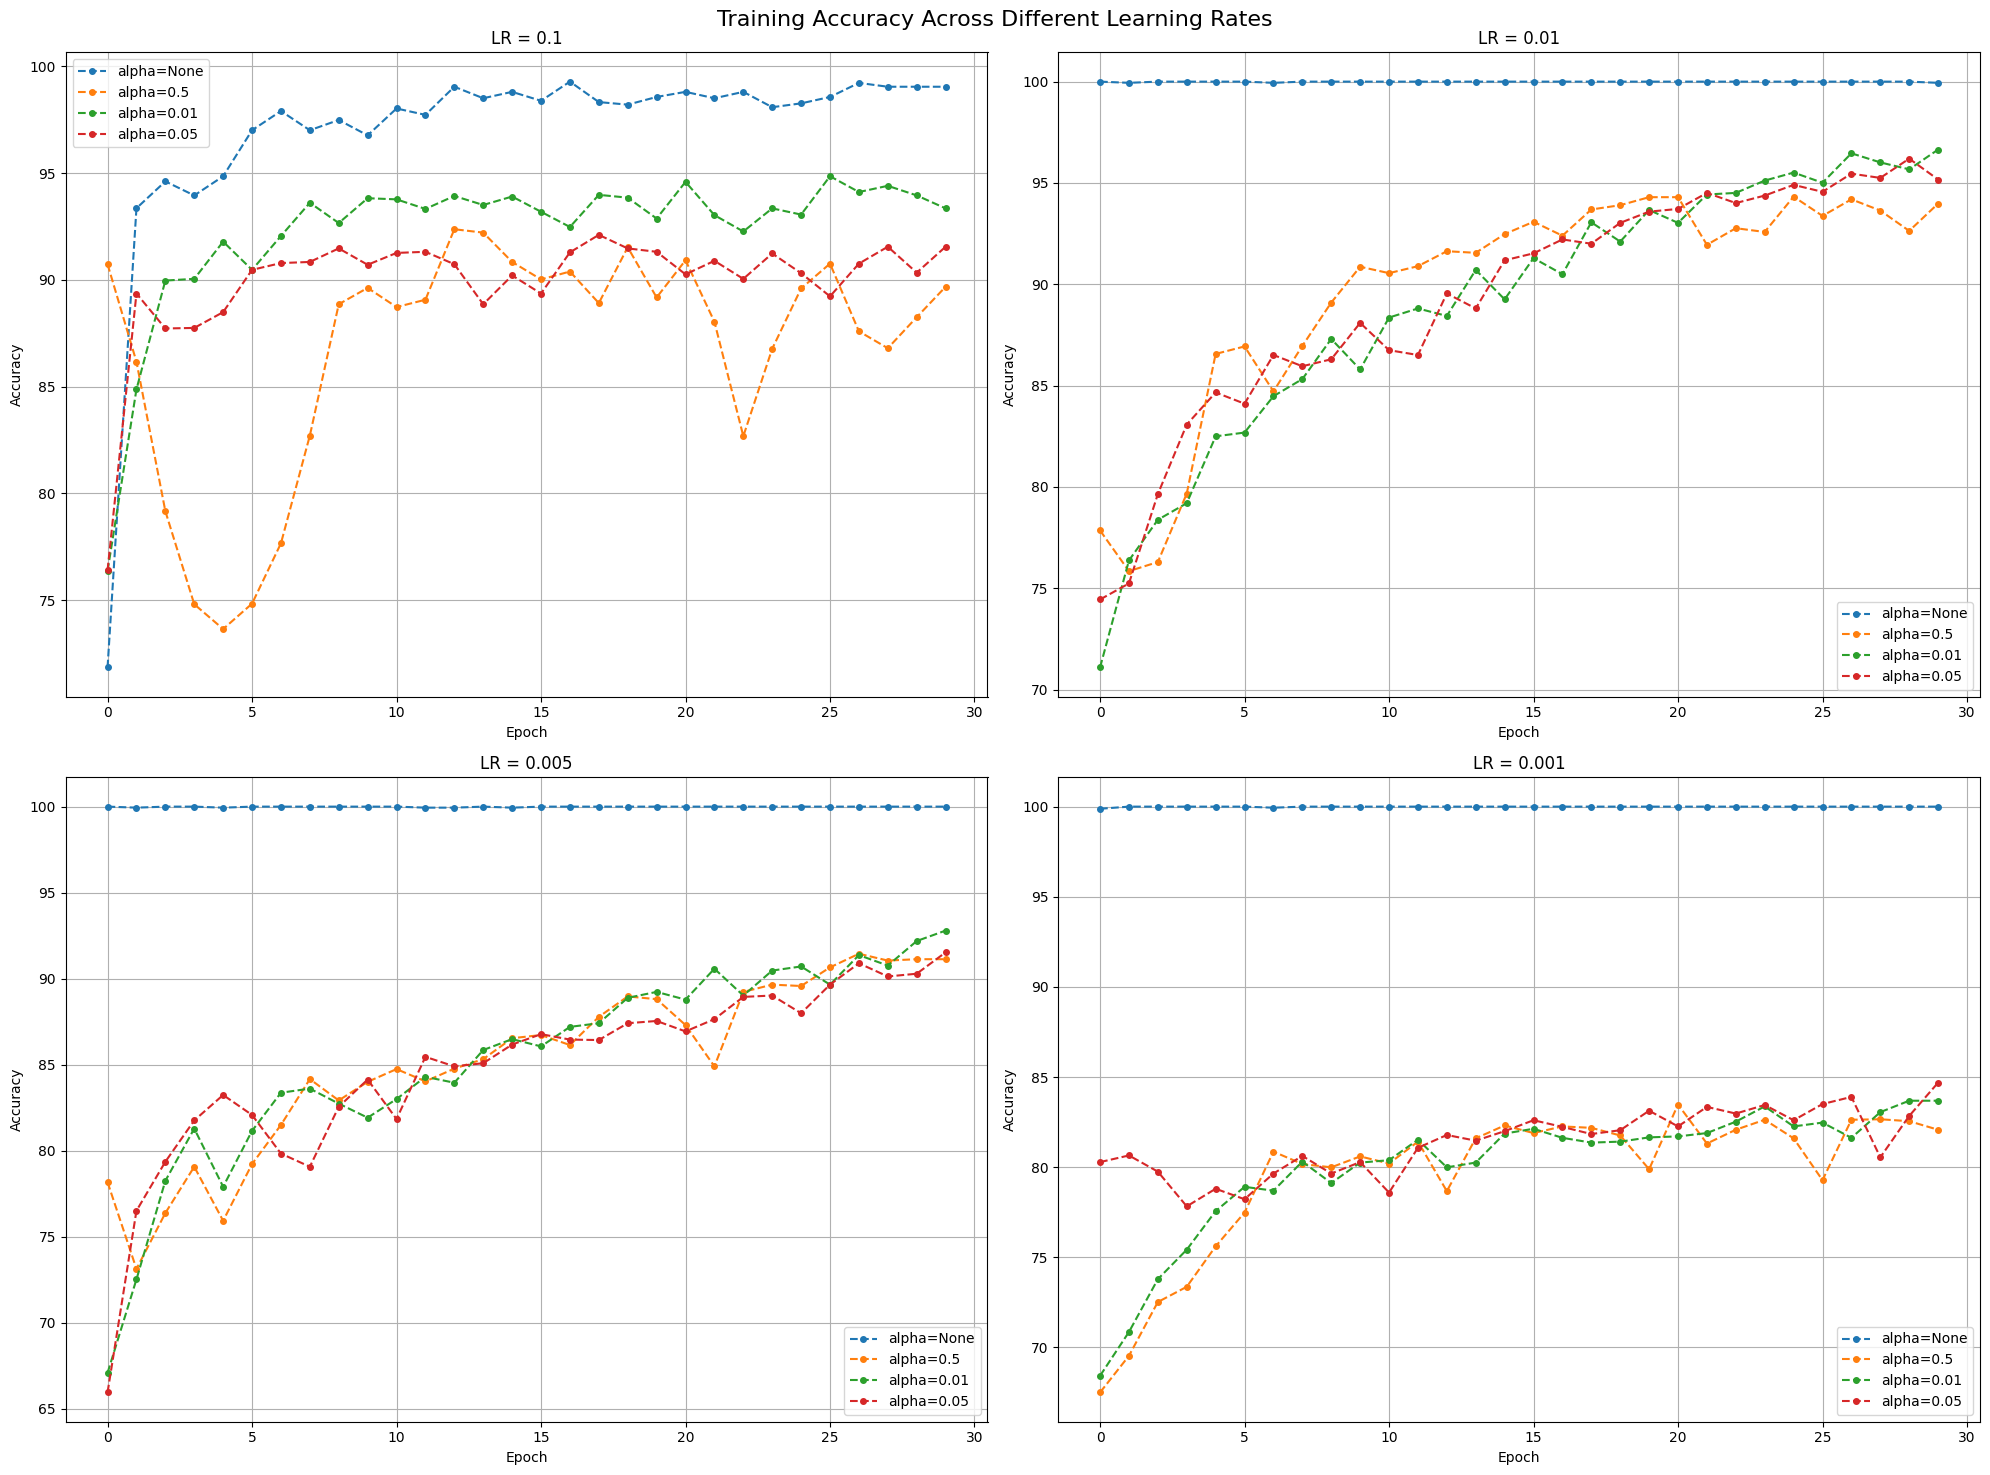

In [ ]:
import matplotlib.pyplot as plt

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('Training Accuracy Across Different Learning Rates', fontsize=16)

# Organize learning rates and their positions
lrs = {
    '0.1': (0, 0),
    '0.01': (0, 1),
    '0.005': (1, 0),
    '0.001': (1, 1)
}

# Plot each learning rate in its subplot
for key in train_accuracy.keys():
    lr = key.split(', ')[0]
    row, col = lrs[lr]

    axs[row, col].plot(
        train_accuracy[key],
        label=f"alpha={key.split(', ')[1]}",
        linestyle='dashed',
        marker='o',
        markersize=4
    )
    axs[row, col].set_title(f'LR = {lr}')
    axs[row, col].set_xlabel('Epoch')
    axs[row, col].set_ylabel('Accuracy')
    axs[row, col].grid(True)
    axs[row, col].legend()

plt.tight_layout()
plt.show()

### Plot Training loss

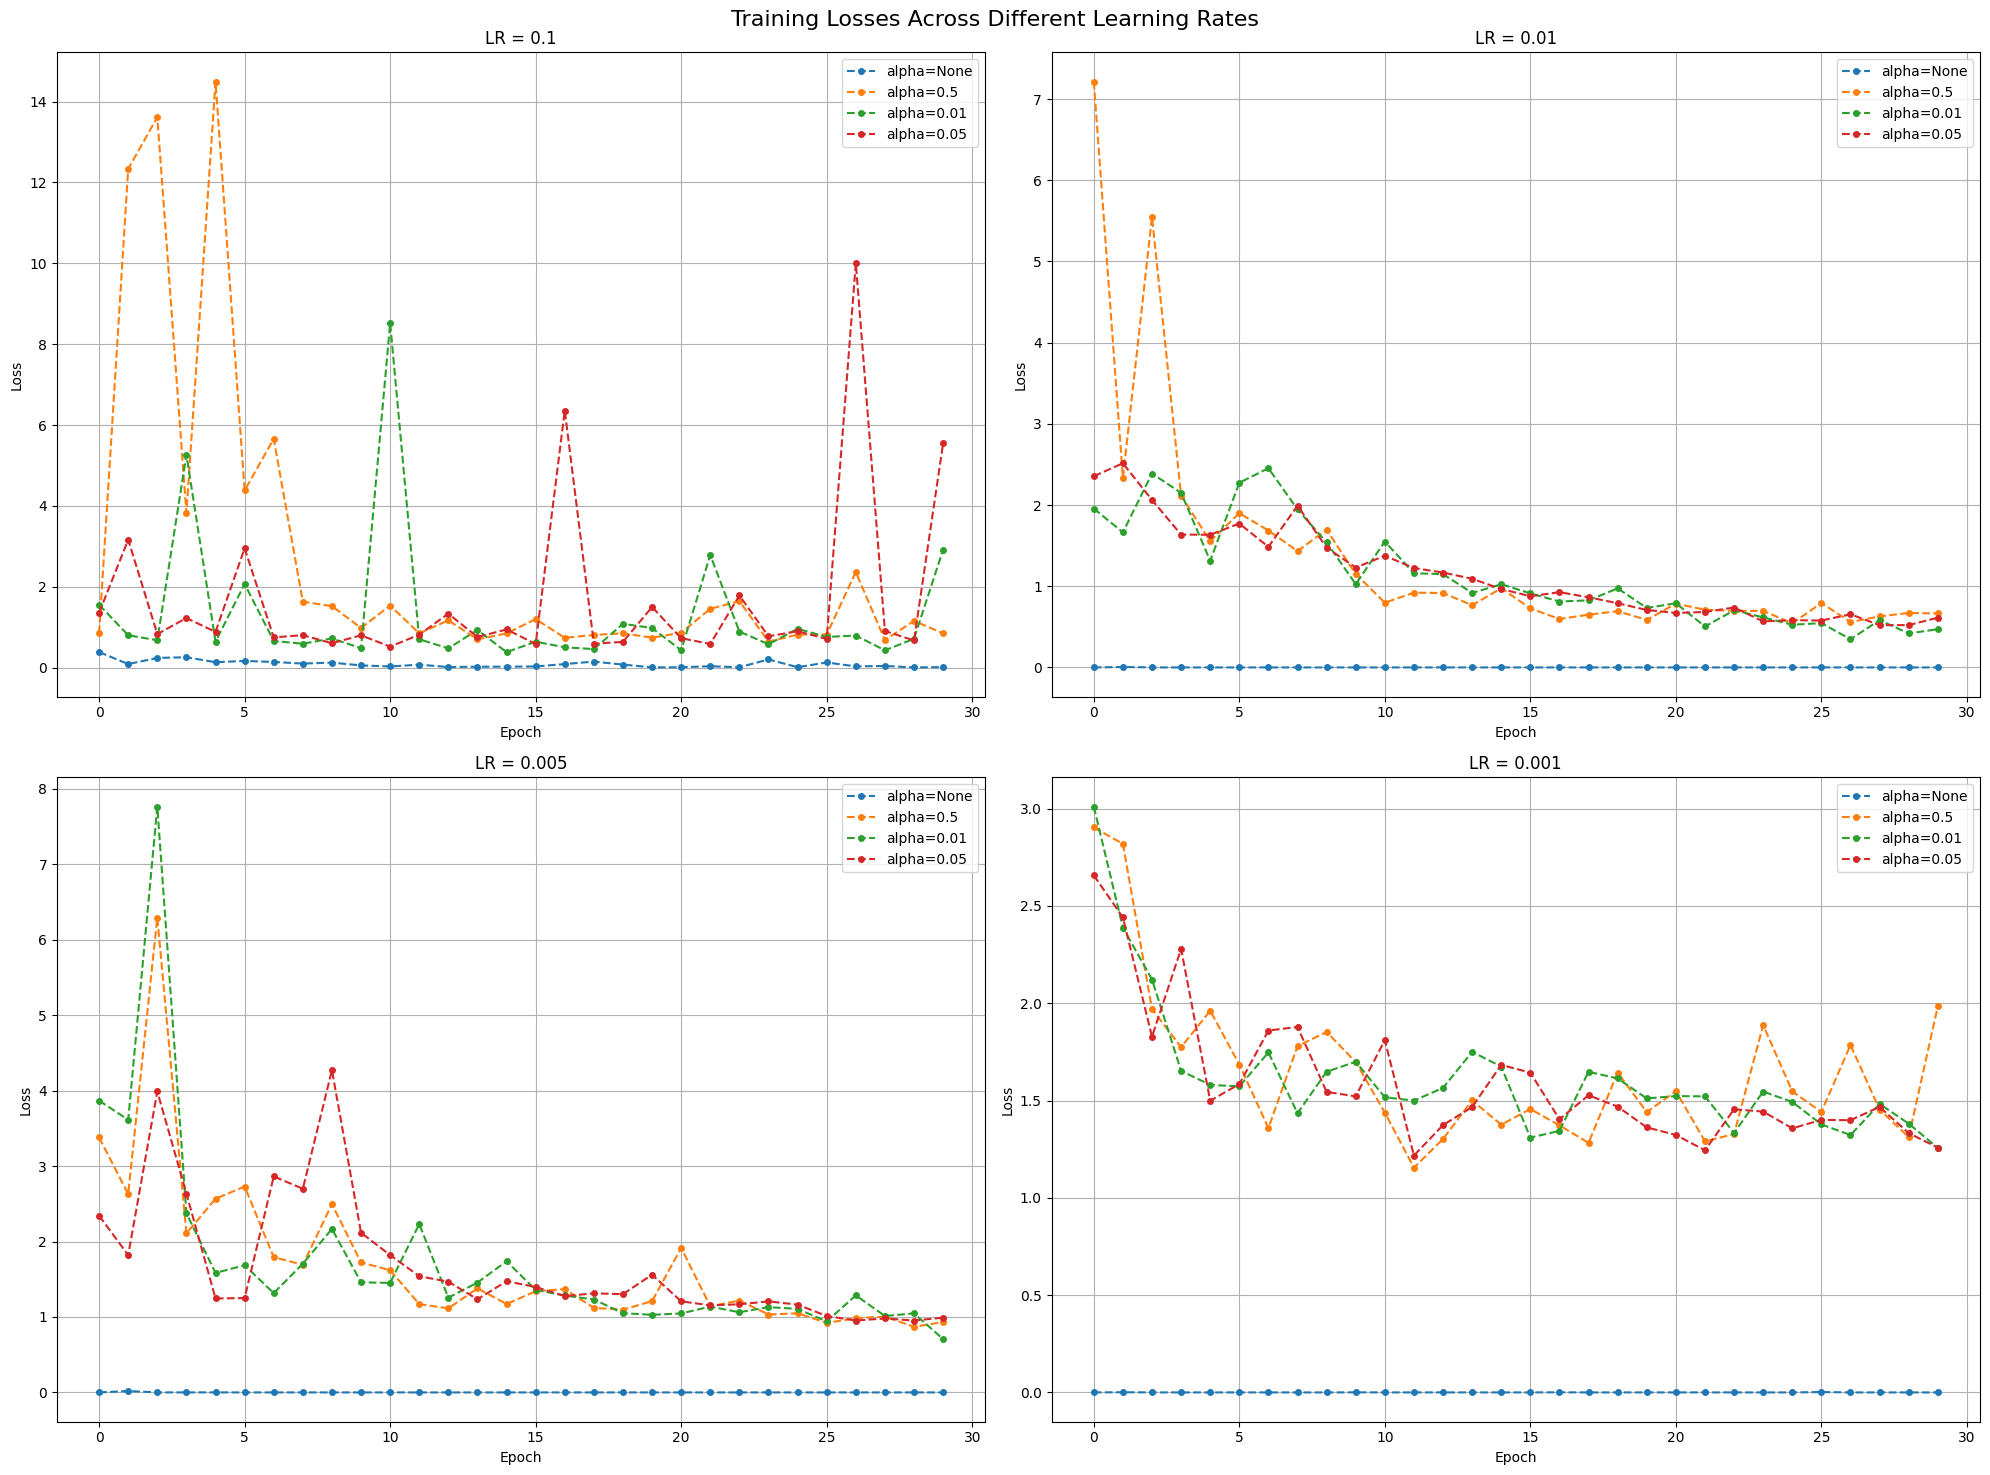

In [ ]:
import matplotlib.pyplot as plt

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('Training Losses Across Different Learning Rates', fontsize=16)

# Organize learning rates and their positions
lrs = {
    '0.1': (0, 0),
    '0.01': (0, 1),
    '0.005': (1, 0),
    '0.001': (1, 1)
}

# Plot each learning rate in its subplot
for key in train_loss.keys():
    lr = key.split(', ')[0]
    row, col = lrs[lr]

    axs[row, col].plot(
        train_loss[key],
        label=f"alpha={key.split(', ')[1]}",
        linestyle='dashed',
        marker='o',
        markersize=4
    )
    axs[row, col].set_title(f'LR = {lr}')
    axs[row, col].set_xlabel('Epoch')
    axs[row, col].set_ylabel('Loss')
    axs[row, col].grid(True)
    axs[row, col].legend()

plt.tight_layout()
plt.show()

# Test - With Domain Adaptation

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
alexnet_test = AlexNet(num_classes=7, pretrained=True)
cartoon_loader = DataLoader(cartoon_domain, batch_size=64, shuffle=False)
sketch_loader = DataLoader(sketch_domain, batch_size=64, shuffle=False)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 233M/233M [00:01<00:00, 191MB/s]


In [ ]:

test_accuracy = {}
test_loss = {}

for LR in hyperparameters["LR"]:
    for ALPHA in hyperparameters["alpha"]:
        key = f"{LR}, {ALPHA}"
        print(f"\nEvaluating model with LR: {LR}, Alpha: {ALPHA}")

        # Initialize metrics storage
        test_accuracy[key] = {
            'cartoon': 0.0,
            'sketch': 0.0,
            'average': 0.0
        }

        test_loss[key] = {
            'cartoon': 0.0,
            'sketch': 0.0,
            'average': 0.0
        }

        # Load model
        model_path = f"/content/drive/MyDrive/saved_models/DA/model/lr_{LR}_alpha_{ALPHA}.pth"
        model = AlexNetDA(alexnet_test, 2).to(DEVICE)
        model.load_state_dict(torch.load(model_path, weights_only=True))
        optimizer_da = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=5e-5)
        criterion = nn.CrossEntropyLoss()


        for epoch in range(5):
          model.train()  # Set the model to training mode


          classifier_loss, domain_loss, target_loss, sketch_target_loss = 0, 0, 0, 0

          for i, (inputs, labels) in enumerate(train_loader):

              inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
              optimizer_da.zero_grad()

              outputs = model(inputs)

              classifier_loss = criterion(outputs, labels)


              if ALPHA is not None:

                outputs_domain = model(inputs, alpha=ALPHA)
                domain_loss = criterion(outputs_domain, torch.zeros(outputs_domain.size(0)).long().to(DEVICE))


                input_target, label_target = next(iter(cartoon_loader))
                input_target = input_target.to(DEVICE)
                label_target = label_target.to(DEVICE)

                outputs_target = model(input_target, alpha=ALPHA)
                target_loss = criterion(outputs_target, torch.ones(outputs_target.size(0)).long().to(DEVICE))


                sketch_input_target, sketch_label_target = next(iter(sketch_loader))
                sketch_input_target = sketch_input_target.to(DEVICE)
                sketch_label_target = sketch_label_target.to(DEVICE)

                sketch_outputs_target = model(sketch_input_target, alpha=ALPHA)
                sketch_target_loss = criterion(sketch_outputs_target, torch.ones(sketch_outputs_target.size(0)).long().to(DEVICE))


              loss = (classifier_loss + domain_loss + target_loss + sketch_target_loss)

              loss.backward()
              clip_grad_norm_(model.parameters(),max_norm=1.0)
              optimizer_da.step()




        # Cartoon domain evaluation
        cartoon_classifier_correct = 0
        cartoon_domain_correct = 0
        cartoon_total = 0
        cartoon_classifier_total = 0
        cartoon_domain_total = 0
        cartoon_classifier_running_loss = 0.0  # Separate classifier loss tracking
        cartoon_domain_running_loss = 0.0  # Separate domain adaptation loss tracking

        model.eval()

        with torch.no_grad():
            for inputs, labels in cartoon_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)  # Classifier output for cartoon

                # Compute classifier loss
                classifier_loss = criterion(outputs, labels)

                # Track classifier accuracy
                _, predicted = torch.max(outputs.data, 1)
                cartoon_classifier_total += labels.size(0)
                cartoon_classifier_correct += (predicted == labels).sum().item()

                if ALPHA is not None:
                    # Compute domain adaptation loss
                    outputs_domain = model(inputs, alpha=ALPHA)
                    domain_loss = criterion(outputs_domain, torch.ones(outputs_domain.size(0)).long().to(DEVICE))  # Domain label for target

                    # Track domain adaptation accuracy
                    _, predicted_domain = torch.max(outputs_domain.data, 1)
                    cartoon_domain_total += labels.size(0)
                    cartoon_domain_correct += (predicted_domain == torch.ones(predicted_domain.size(0)).long().to(DEVICE)).sum().item()

                    cartoon_domain_running_loss += domain_loss.item() * inputs.size(0)

                cartoon_classifier_running_loss += classifier_loss.item() * inputs.size(0)

                cartoon_total += labels.size(0)

        # Sketch domain evaluation
        sketch_classifier_correct = 0
        sketch_domain_correct = 0
        sketch_total = 0
        sketch_classifier_total = 0
        sketch_domain_total = 0
        sketch_classifier_running_loss = 0.0  # Separate classifier loss tracking
        sketch_domain_running_loss = 0.0  # Separate domain adaptation loss tracking

        with torch.no_grad():
            for inputs, labels in sketch_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)  # Classifier output for sketch

                # Compute classifier loss
                classifier_loss = criterion(outputs, labels)

                # Track classifier accuracy
                _, predicted = torch.max(outputs.data, 1)
                sketch_classifier_total += labels.size(0)
                sketch_classifier_correct += (predicted == labels).sum().item()

                if ALPHA is not None:
                    # Compute domain adaptation loss
                    outputs_domain = model(inputs, alpha=ALPHA)
                    domain_loss = criterion(outputs_domain, torch.ones(outputs_domain.size(0)).long().to(DEVICE))  # Domain label for target

                    # Track domain adaptation accuracy
                    _, predicted_domain = torch.max(outputs_domain.data, 1)
                    sketch_domain_total += labels.size(0)
                    sketch_domain_correct += (predicted_domain == torch.ones(predicted_domain.size(0)).long().to(DEVICE)).sum().item()

                    sketch_domain_running_loss += domain_loss.item() * inputs.size(0)

                sketch_classifier_running_loss += classifier_loss.item() * inputs.size(0)

                sketch_total += labels.size(0)

        # Calculate accuracy
        cartoon_accuracy = 100 * (cartoon_classifier_correct + cartoon_domain_correct) / (cartoon_classifier_total + cartoon_domain_total)
        sketch_accuracy = 100 * (sketch_classifier_correct + sketch_domain_correct) / (sketch_classifier_total + sketch_domain_total)
        average_accuracy = (cartoon_accuracy + sketch_accuracy) / 2

        # Compute final loss values
        cartoon_classifier_loss = cartoon_classifier_running_loss / cartoon_total
        cartoon_domain_loss = cartoon_domain_running_loss / cartoon_total
        cartoon_total_loss = cartoon_classifier_loss + cartoon_domain_loss  # Sum both losses

        sketch_classifier_loss = sketch_classifier_running_loss / sketch_total
        sketch_domain_loss = sketch_domain_running_loss / sketch_total
        sketch_total_loss = sketch_classifier_loss + sketch_domain_loss  # Sum both losses

        average_loss = (cartoon_total_loss + sketch_total_loss) / 2

        # Store results
        test_accuracy[key]['cartoon'] = cartoon_accuracy
        test_accuracy[key]['sketch'] = sketch_accuracy
        test_accuracy[key]['average'] = average_accuracy

        test_loss[key]['cartoon'] = cartoon_total_loss
        test_loss[key]['sketch'] = sketch_total_loss
        test_loss[key]['average'] = average_loss

        # Print results
        print(f"Cartoon Domain -> Classifier Loss: {cartoon_classifier_loss:.4f}, Domain Loss: {cartoon_domain_loss:.4f}, Total Loss: {cartoon_total_loss:.4f}, Accuracy: {cartoon_accuracy:.2f}%")
        print(f"Sketch Domain -> Classifier Loss: {sketch_classifier_loss:.4f}, Domain Loss: {sketch_domain_loss:.4f}, Total Loss: {sketch_total_loss:.4f}, Accuracy: {sketch_accuracy:.2f}%")
        print(f"Average Loss: {average_loss:.4f}, Average Accuracy: {average_accuracy:.2f}%")



Evaluating model with LR: 0.1, Alpha: None
Cartoon Domain -> Classifier Loss: 7.0091, Domain Loss: 0.0000, Total Loss: 7.0091, Accuracy: 23.04%
Sketch Domain -> Classifier Loss: 4.4014, Domain Loss: 0.0000, Total Loss: 4.4014, Accuracy: 22.60%
Average Loss: 5.7052, Average Accuracy: 22.82%

Evaluating model with LR: 0.1, Alpha: 0.5
Cartoon Domain -> Classifier Loss: 10.7819, Domain Loss: 3.3521, Total Loss: 14.1340, Accuracy: 49.38%
Sketch Domain -> Classifier Loss: 7.0458, Domain Loss: 0.0243, Total Loss: 7.0701, Accuracy: 63.93%
Average Loss: 10.6020, Average Accuracy: 56.66%

Evaluating model with LR: 0.1, Alpha: 0.01
Cartoon Domain -> Classifier Loss: 8.4912, Domain Loss: 7.9442, Total Loss: 16.4355, Accuracy: 52.99%
Sketch Domain -> Classifier Loss: 6.7974, Domain Loss: 0.4880, Total Loss: 7.2855, Accuracy: 61.49%
Average Loss: 11.8605, Average Accuracy: 57.24%

Evaluating model with LR: 0.1, Alpha: 0.05
Cartoon Domain -> Classifier Loss: 11.6355, Domain Loss: 5.6225, Total Loss:

# Feature Extraction

In [35]:
def extract_features(model, dataloader, device, alpha=None):
    model.eval()  # Set model to evaluation mode
    features = []
    labels = []

    with torch.no_grad():
        for images, target_labels in dataloader:
            images = images.to(device)
            target_labels = target_labels.to(device)

            # Extract features from the penultimate layer (before the classifier)
            # Forward pass through the model
            feature_output = model(images, alpha=alpha)
            features.append(feature_output.cpu().numpy())  # Convert to numpy for later analysis
            labels.append(target_labels.cpu().numpy())

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels


In [40]:

# ---------------------- WITHOUT DOMAIN ADAPTATION ----------------------------------
model_path = f"/content/drive/MyDrive/saved_models/DA/model/lr_{0.01}_alpha_{None}.pth"
model = AlexNetDA(alexnet_test, 2).to(DEVICE)
model.load_state_dict(torch.load(model_path, weights_only=True))

feature_source, label_source = extract_features(model, train_loader, DEVICE)
feature_target, label_target = extract_features(model, test_loader, DEVICE)

# ---------------------- WITH DOMAIN ADAPTATION ------------------------------------
model_path = f"/content/drive/MyDrive/saved_models/DA/model/lr_{0.01}_alpha_{0.5}.pth"
model_da = AlexNetDA(alexnet_test, 2).to(DEVICE)
model_da.load_state_dict(torch.load(model_path, weights_only=True))

feature_source_da, label_source_da = extract_features(model_da, train_loader, DEVICE, alpha=0.01)
feature_target_da, label_target_da = extract_features(model_da, test_loader, DEVICE, alpha=0.01)

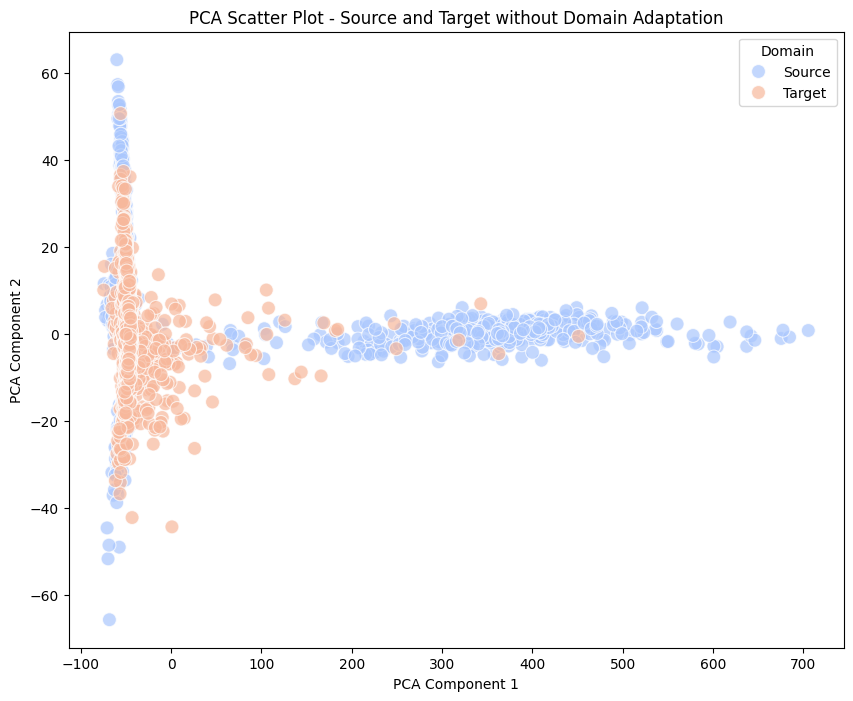

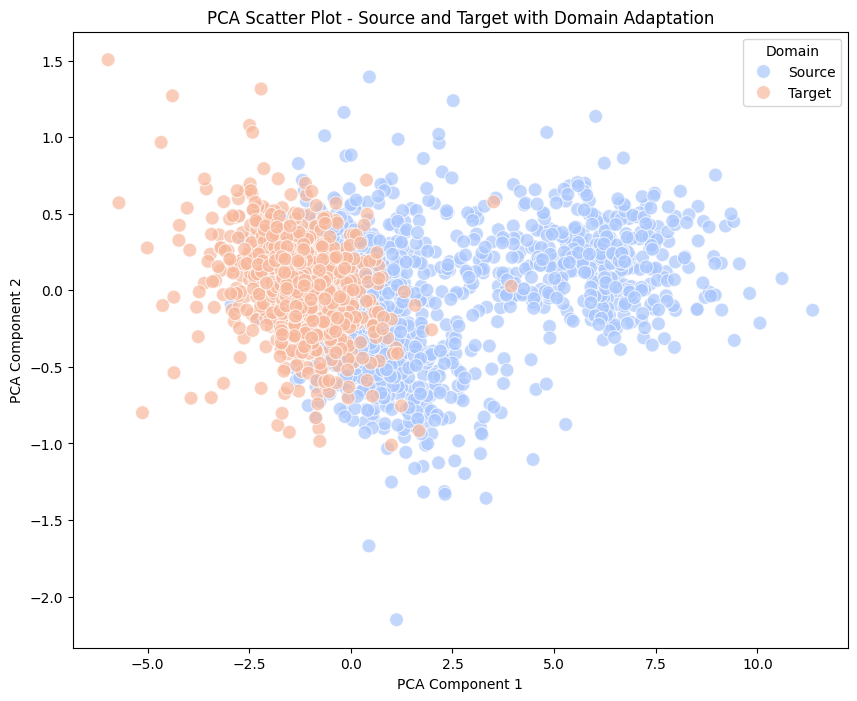

In [44]:
# Function to plot scatter plot of PCA features
def plot_pca_scatter(features, labels, title):
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(features)

    # Extract the PCA components
    pca_x = reduced_features[:, 0]
    pca_y = reduced_features[:, 1]

    # Create a DataFrame for easier plotting with color coding based on the domain
    data = {
        'PCA Component 1': pca_x,
        'PCA Component 2': pca_y,
        'Domain': ['Source'] * len(label_source) + ['Target'] * len(label_target)
    }

    df = pd.DataFrame(data)

    # Plot the scatter plot
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=df, x='PCA Component 1', y='PCA Component 2', hue='Domain', palette='coolwarm', s=100, alpha=0.7)
    plt.title(f'PCA Scatter Plot - {title}')
    plt.legend(title="Domain")
    plt.show()

# ---------------------- WITHOUT DOMAIN ADAPTATION ----------------------------------
# Combine source and target features for PCA visualization
features_combined_no_da = np.vstack([feature_source, feature_target])
labels_combined_no_da = np.hstack([label_source, label_target])

# Plot PCA scatter plot for features without domain adaptation
plot_pca_scatter(features_combined_no_da, labels_combined_no_da, title="Source and Target without Domain Adaptation")

# ---------------------- WITH DOMAIN ADAPTATION ----------------------------------
# Combine source and target features for PCA visualization
features_combined_da = np.vstack([feature_source_da, feature_target_da])
labels_combined_da = np.hstack([label_source_da, label_target_da])

# Plot PCA scatter plot for features with domain adaptation
plot_pca_scatter(features_combined_da, labels_combined_da, title="Source and Target with Domain Adaptation")
